In [1]:
import pandas as pd
import pickle as pk
import matplotlib.pyplot as plt
import tqdm
from sklearn.model_selection import train_test_split
import seaborn as sns
import numpy as np

import torch
import torch.nn as nn
import torch.optim as optim
import tqdm
from pyro.infer import MCMC, NUTS

/usr/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
ground_motion = pd.read_pickle("data/processed_ground_motion_PGA.pkl")

In [3]:
X = ground_motion[['Earthquake Magnitude', 'EpiD (km)', 'Vs30 (m/s) selected for analysis']].values
y = ground_motion['PGA (g)'].values

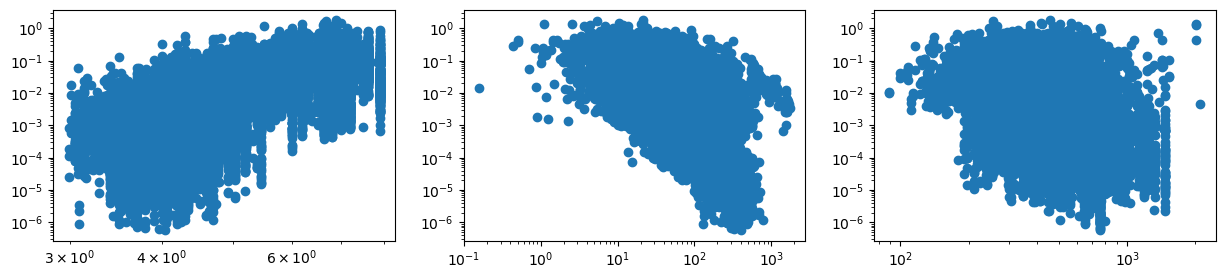

In [4]:
f, ax = plt.subplots(1,3,figsize=(15, 3))
for i in range(3):
    ax[i].scatter(X[:,i],y)
    ax[i].set_yscale('log')
    ax[i].set_xscale('log')
plt.savefig('corr_inp_m_d_vs30.pdf', bbox_inches='tight')

(array([ 883., 4681., 4685., 2397., 1386., 1052., 1891., 2438.,  867.,
         724.]),
 array([2.99 , 3.481, 3.972, 4.463, 4.954, 5.445, 5.936, 6.427, 6.918,
        7.409, 7.9  ]),
 <BarContainer object of 10 artists>)

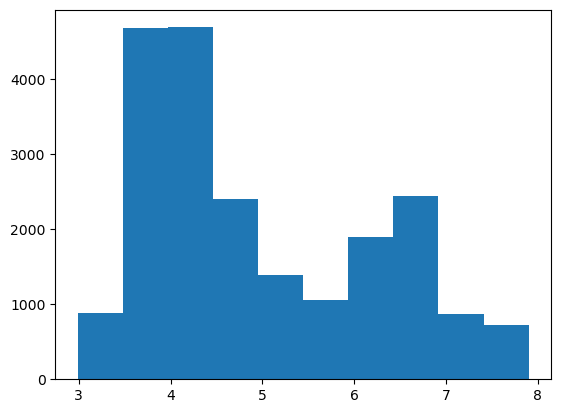

In [5]:
plt.hist(X[:,0])

In [6]:
interest_index = (ground_motion['Earthquake Magnitude'] > 6.0) & (ground_motion['Earthquake Magnitude'] < 7.0)

In [7]:
ground_motion2 = ground_motion[interest_index]

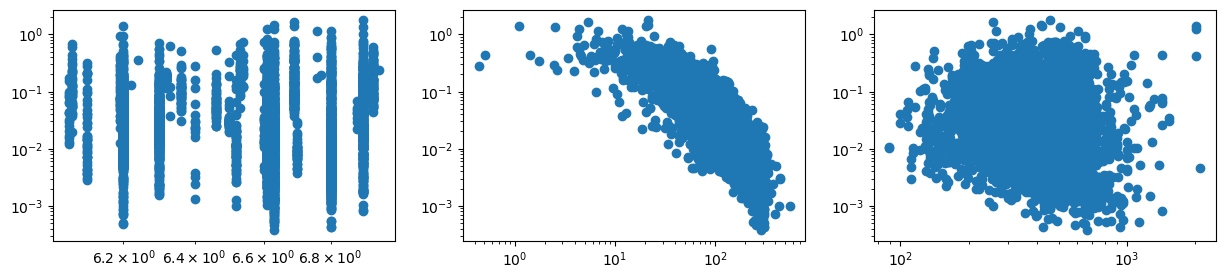

In [8]:
f, ax = plt.subplots(1,3,figsize=(15, 3))
for i,inps in enumerate(['Earthquake Magnitude', 'EpiD (km)', 'Vs30 (m/s) selected for analysis']):
    ax[i].scatter(ground_motion2[inps],ground_motion2['PGA (g)'])
    ax[i].set_yscale('log')
    ax[i].set_xscale('log')
plt.savefig('corr_inp_m_d_vs30.pdf', bbox_inches='tight')

/usr/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/usr/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/usr/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


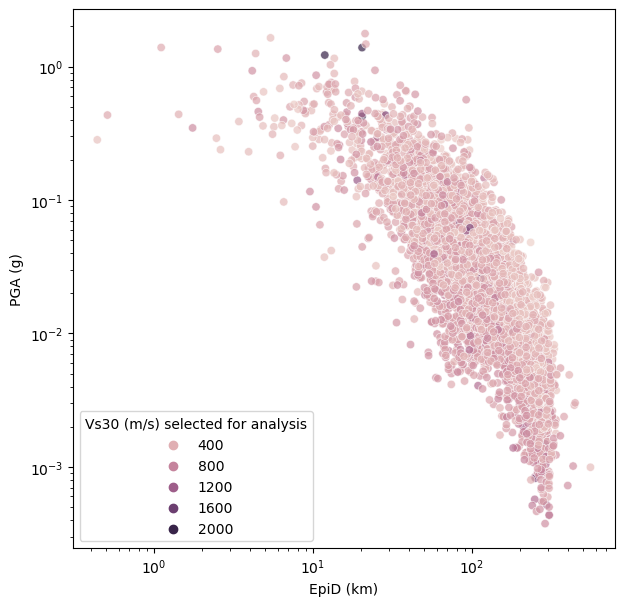

In [9]:
f, ax = plt.subplots(figsize=(7, 7))
ax.set(xscale="log", yscale="log")
sns.scatterplot(data=ground_motion2, x="EpiD (km)", y="PGA (g)",hue="Vs30 (m/s) selected for analysis", alpha=0.7)
ax.set(xscale="log", yscale="log")
plt.savefig('Interim_Report/PGA_Mag_Width.png', bbox_inches='tight')

In [10]:
class NonlinearRegressionModel02(nn.Module):
    def __init__(self):
        super(NonlinearRegressionModel02, self).__init__()
        self.hidden1 = nn.Linear(2, 300)
        self.hidden2 = nn.Linear(300, 200)
        self.hidden3 = nn.Linear(200, 100)
        self.hidden4 = nn.Linear(100, 50)
        self.hidden5 = nn.Linear(50, 10)
        self.hidden6 = nn.Linear(10, 10)
        self.output = nn.Linear(10, 1) 
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.relu(self.hidden1(x))
        x = self.relu(self.hidden2(x))
        x = self.relu(self.hidden3(x))
        x = self.relu(self.hidden4(x))
        x = self.relu(self.hidden5(x))
        x = self.relu(self.hidden6(x))
        x = self.output(x)
        return x

In [11]:
y = np.log(ground_motion2['PGA (g)'].values)
X = ground_motion2[['EpiD (km)', 'Vs30 (m/s) selected for analysis']].values
# We added shuffling to introduce stochasticity
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.6, shuffle=True)

In [12]:
X_train = torch.tensor(X_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32).reshape(-1, 1)
X_test = torch.tensor(X_test, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.float32).reshape(-1, 1)

In [13]:
model01 = NonlinearRegressionModel02()
# Define loss and optimizer
loss_fn = nn.MSELoss()  # Mean Squared Error loss
optimizer = optim.Adam(model01.parameters(), lr=0.0001)  # Adam optimizer

# Training loop
n_epochs = 200   # number of epochs to run
batch_size = 10  # size of each batch
batch_start = torch.arange(0, len(X_train), batch_size)

# Hold the best model
best_mse = np.inf   # init to infinity
best_weights = None
history_train = []
history_test = []
for epoch in range(n_epochs):
    outputs = model01(X_train)
    loss = loss_fn(outputs, y_train)
    # Backward pass and optimization
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    if (epoch + 1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{n_epochs}], Loss: {loss.item():.4f}')
    y_pred = model01(X_test)
    mse = loss_fn(y_pred, y_test)
    mse = float(mse)
    history_test.append(mse)
    y_pred = model01(X_train)
    mse = loss_fn(y_pred, y_train)
    mse = float(mse)
    history_train.append(mse)
loss01 = loss.item()

Epoch [10/200], Loss: 9.9120
Epoch [20/200], Loss: 5.9148
Epoch [30/200], Loss: 2.8328
Epoch [40/200], Loss: 2.3061
Epoch [50/200], Loss: 1.6924
Epoch [60/200], Loss: 1.2936
Epoch [70/200], Loss: 1.0330
Epoch [80/200], Loss: 0.9029
Epoch [90/200], Loss: 0.8591
Epoch [100/200], Loss: 0.8368
Epoch [110/200], Loss: 0.8180
Epoch [120/200], Loss: 0.8007
Epoch [130/200], Loss: 0.7897
Epoch [140/200], Loss: 0.7811
Epoch [150/200], Loss: 0.7741
Epoch [160/200], Loss: 0.7687
Epoch [170/200], Loss: 0.7643
Epoch [180/200], Loss: 0.7606
Epoch [190/200], Loss: 0.7574
Epoch [200/200], Loss: 0.7544


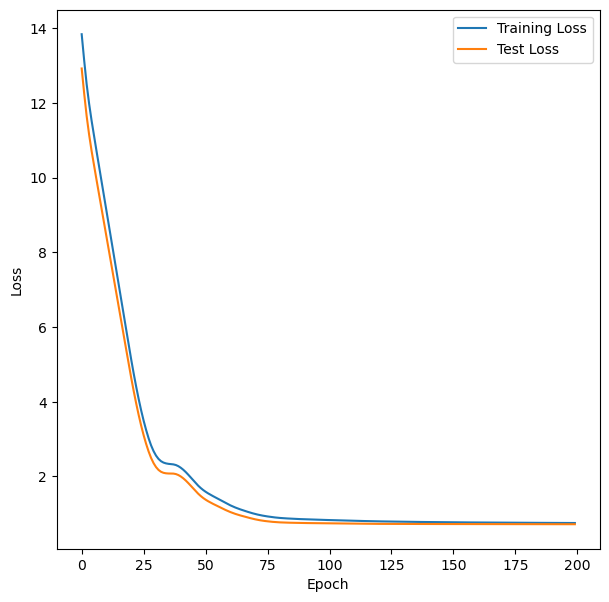

In [14]:
f, ax = plt.subplots(figsize=(7, 7))
plt.plot(history_train, label='Training Loss')
plt.plot(history_test, label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

In [15]:
X_trial1 = np.zeros([101,2])
X_trial2 = np.zeros([101,2])
X_trial3 = np.zeros([101,2])
X_trial4 = np.zeros([101,2])

X_trial1[:,0] = 10**np.linspace(0,2.5,101)
X_trial2[:,0] = 10**np.linspace(0,2.5,101)
X_trial3[:,0] = 10**np.linspace(0,2.5,101)
X_trial4[:,0] = 10**np.linspace(0,2.5,101)
X_trial1[:,1] = 100
X_trial2[:,1] = 400
X_trial3[:,1] = 700
X_trial4[:,1] = 1000

In [16]:
X_trial1 = torch.tensor(X_trial1, dtype=torch.float32)
X_trial2 = torch.tensor(X_trial2, dtype=torch.float32)
X_trial3 = torch.tensor(X_trial3, dtype=torch.float32)
X_trial4 = torch.tensor(X_trial4, dtype=torch.float32)
Y_trial1 = model01(X_trial1)
Y_trial2 = model01(X_trial2)
Y_trial3 = model01(X_trial3)
Y_trial4 = model01(X_trial4)

/usr/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/usr/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/usr/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


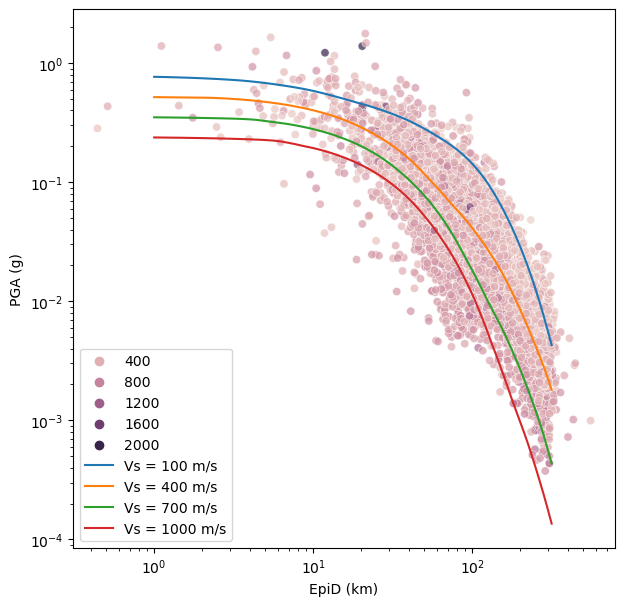

In [21]:
f, ax = plt.subplots(figsize=(7, 7))
ax.set(xscale="log", yscale="log")
sns.scatterplot(data=ground_motion2, x="EpiD (km)", y="PGA (g)",hue="Vs30 (m/s) selected for analysis", alpha=0.7)
ax.set(xscale="log", yscale="log")
plt.plot(10**np.linspace(0,2.5,101),torch.exp(Y_trial1).detach().cpu().numpy(), label='Vs = 100 m/s')
plt.plot(10**np.linspace(0,2.5,101),torch.exp(Y_trial2).detach().cpu().numpy(), label='Vs = 400 m/s')
plt.plot(10**np.linspace(0,2.5,101),torch.exp(Y_trial3).detach().cpu().numpy(), label='Vs = 700 m/s')
plt.plot(10**np.linspace(0,2.5,101),torch.exp(Y_trial4).detach().cpu().numpy(), label='Vs = 1000 m/s')
plt.legend()

In [18]:
indx = 0
DNN_param = {}
for layer in model01.children():
    if isinstance(layer, nn.Linear):
        DNN_param[indx] = {'weight':layer.state_dict()['weight'],\
                           'bias':layer.state_dict()['bias']}
        indx = indx + 1

In [19]:
DNN_param.keys()

dict_keys([0, 1, 2, 3, 4, 5, 6])

In [20]:
with open('data/DNN_param.pkl', 'wb') as file:
    pk.dump(DNN_param, file)